In [30]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import warnings # I HAVE THIS TO SUPPRESS WARNINGS ON MISSING VALUES (not errors)
warnings.simplefilter(action = "ignore", category = RuntimeWarning)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
/kaggle/input/new-york-city-airbnb-open-data/AB_NYC_2019.csv
/kaggle/input/new-york-city-airbnb-open-data/New_York_City_.png


In [31]:
df = pd.read_csv('/kaggle/input/new-york-city-airbnb-open-data/AB_NYC_2019.csv')
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


# Question 1

There are several columns - id, name, host_id, host_name, neightbourhood_group, and so on with almost 49000 entries. 

In [32]:
# mask = df.isna() # Figure out which entries are missing via True or not (False) 
mask = df.isna().sum() # Figure out number of missing values in column, 16 missing in name, 21 in host_name, and 10052 for last_review & reviews_permonth
print(mask)

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64


After a close inspection of dataframe using df.head() and df.tail(), I found the two columns 'name' and 'host_name' to be not that important in general for the assignment. This is because there is only 16 and 21 missing values, respectively, from ~ 49k records. The significance of having accurate imputation is minimal in affecting the dataset. 

As a result, I will impute the name field with a value of the form: "room_type" in "neighbourhood" columns to indicate relevant values. Additionally, as for host_name, I will impute "Anonymous". 

In [5]:
mask = df['name'].isna() # Get which records are empty (true)
df.loc[mask, 'name'] = df['room_type'].fillna('') + ' ' + df['neighbourhood'].fillna('') # Fill empty value of the format: "Room_type in neighbourhood_name"
df['host_name'] = df['host_name'].fillna('Unknown') # As for hostname, impute "Unknown"
print(df.isna().sum()) # Check status of missing values now

id                                    0
name                                  0
host_id                               0
host_name                             0
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64


Now that the two columns have been taken care of, now I need to focus on last_review & reviews_per_month. Both of these have way too many values missing, almost 20% of the dataset for these columns respectively. An interesting point is that both are missing the exact same amount, which could be the rows are related. After further inspection of the data, I found they are indeed related to one another. 

In [79]:
out = df[(df['last_review'].isna()) | (df['reviews_per_month'].isna())] # Return all rows where either last_review or reviews_per_month is missing
# out.describe()
# out.tail()
out.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,hostings_range,reviews_range
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365,0-10,0-50
19,7750,Huge 2 BR Upper East Cental Park,17985,Sing,Manhattan,East Harlem,40.79685,-73.94872,Entire home/apt,190,7,0,NaN,NaN,2,249,0-10,0-50
26,8700,Magnifique Suite au N de Manhattan - vue Cloitres,26394,Claude & Sophie,Manhattan,Inwood,40.86754,-73.92639,Private room,80,4,0,NaN,NaN,1,0,0-10,0-50
36,11452,Clean and Quiet in Brooklyn,7355,Vt,Brooklyn,Bedford-Stuyvesant,40.68876,-73.94312,Private room,35,60,0,NaN,NaN,1,365,0-10,0-50
38,11943,Country space in the city,45445,Harriet,Brooklyn,Flatbush,40.63702,-73.96327,Private room,150,1,0,NaN,NaN,1,365,0-10,0-50


As it can be seen, the columns are indeed related as the average, min, and max for the number_of_reviews column is 0 and there are precisely 10,052 records indicating the relation of missing both values when this is the case. If there are 0 reviews for these, then I can impute 0 for "reviews_per_month" column, and a custom value like "Unreviewed" for "last_review" column. 

In [7]:
df['reviews_per_month'] = df['reviews_per_month'].fillna(0) # Fill missing values with "0" for reviews_per_month column
df['last_review'] = df['last_review'].fillna('Unreviewed') # Fill missing values of last_review with "Unreviewed"
print(df.isna().sum())

id                                0
name                              0
host_id                           0
host_name                         0
neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
last_review                       0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64


In [8]:
df.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,4.889500e+04,4.889500e+04,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000
mean,1.901714e+07,6.762001e+07,40.728949,-73.952170,152.720687,7.029962,23.274466,1.090910,7.143982,112.781327
std,1.098311e+07,7.861097e+07,0.054530,0.046157,240.154170,20.510550,44.550582,1.597283,32.952519,131.622289
min,2.539000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,9.471945e+06,7.822033e+06,40.690100,-73.983070,69.000000,1.000000,1.000000,0.040000,1.000000,0.000000
50%,1.967728e+07,3.079382e+07,40.723070,-73.955680,106.000000,3.000000,5.000000,0.370000,1.000000,45.000000
75%,2.915218e+07,1.074344e+08,40.763115,-73.936275,175.000000,5.000000,24.000000,1.580000,2.000000,227.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


Even though missing values were fixed with imputation, there is a problem as can be seen above with outliers. For example, the max value for minimum_nights reads 1250 days, which is almost 4 years! And, there is a max of 10,000 dollars for daily price. This is unreasonable for a per-day basis as mean for price column is around 152 dollars, a reasonable average daily price for airbnbs. And, there is a problem where there is airbnb with price 0. For that, I will get a count to see how many have price 0

In [9]:
out = df[df['price'] == 0] # Get only listings with price = 0
out.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,1.100000e+01,1.100000e+01,11.000000,11.000000,11.0,11.000000,11.000000,11.000000,11.000000,11.000000
mean,2.057179e+07,5.862573e+07,40.712058,-73.925670,0.0,7.363636,34.272727,1.579091,4.272727,120.909091
std,6.767257e+05,4.828458e+07,0.045317,0.025821,0.0,11.262972,41.523706,1.906628,2.053821,112.128011
min,1.875060e+07,1.641537e+06,40.681730,-73.975970,0.0,1.000000,0.000000,0.000000,1.000000,0.000000
25%,2.056598e+07,1.192073e+07,40.686510,-73.943585,0.0,1.500000,2.500000,0.130000,3.000000,14.000000
50%,2.063963e+07,8.632710e+07,40.692110,-73.913420,0.0,2.000000,12.000000,0.530000,5.000000,127.000000
75%,2.078688e+07,9.414883e+07,40.716500,-73.910490,0.0,4.500000,74.000000,3.420000,6.000000,199.000000
max,2.130432e+07,1.316976e+08,40.832960,-73.886680,0.0,30.000000,95.000000,4.370000,6.000000,333.000000


Given that there are only 11 records with price = 0, I will remove these 11 records as the count is insignificant for the larger dataset. 

In [10]:
# Remove price = 0 columns, 11 only
df = df[df["price"] > 0] # Filter out such listings
df.describe() # Only 11 removed, 48895 --> 48884 (count)

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,4.888400e+04,4.888400e+04,48884.000000,48884.000000,48884.000000,48884.000000,48884.000000,48884.000000,48884.000000,48884.000000
mean,1.901679e+07,6.762203e+07,40.728953,-73.952176,152.755053,7.029887,23.271991,1.090800,7.144628,112.779498
std,1.098432e+07,7.861666e+07,0.054532,0.046159,240.170260,20.512224,44.551331,1.597213,32.956185,131.627271
min,2.539000e+03,2.438000e+03,40.499790,-74.244420,10.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,9.470548e+06,7.817310e+06,40.690100,-73.983080,69.000000,1.000000,1.000000,0.040000,1.000000,0.000000
50%,1.967574e+07,3.079257e+07,40.723080,-73.955685,106.000000,3.000000,5.000000,0.370000,1.000000,45.000000
75%,2.915297e+07,1.074344e+08,40.763120,-73.936290,175.000000,5.000000,24.000000,1.580000,2.000000,227.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


In [11]:
out = df[df["price"] < 20] # Current minimum airbnb listing in New York is $ 20 (checked online on 03/28/2025)
out.head(n=10)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
2860,1620248,Large furnished 2 bedrooms- - 30 days Minimum,2196224,Sally,Manhattan,East Village,40.73051,-73.98140,Entire home/apt,10,30,0,Unreviewed,0.00,4,137
3950,2459916,"$455 Cozy 1bd, BKLYN Sublet March",12577771,Victor,Brooklyn,Bedford-Stuyvesant,40.68948,-73.93528,Private room,18,1,0,Unreviewed,0.00,1,0
4647,3258197,Large 1br Duplex in Heart of Upper East Side,16477306,Jeff,Manhattan,Upper East Side,40.76866,-73.95553,Entire home/apt,16,2,21,2019-06-30,1.69,1,9
5542,4031809,Prewar classic NYC apartment.,20902552,Miquel,Manhattan,Washington Heights,40.83456,-73.94344,Private room,16,14,0,Unreviewed,0.00,1,0
8169,6301965,Beautiful SoHo Loft,655506,Silvia,Manhattan,SoHo,40.72340,-73.99967,Entire home/apt,16,3,3,2018-01-08,0.16,1,0
8270,6364324,The Oasis.,33106693,Elena,Manhattan,Harlem,40.82159,-73.95013,Private room,16,2,43,2019-07-01,1.66,3,154
19922,15966074,Evergreen Upper Bed for Female Traveler 紐約民宿,101491116,Tong,Brooklyn,Cypress Hills,40.68313,-73.87077,Shared room,19,2,76,2019-06-20,2.40,6,120
20992,16620607,Spacious and Modern 2 Bedroom Apartment,109725962,Erika,Brooklyn,Bushwick,40.68994,-73.91556,Entire home/apt,11,2,113,2019-06-22,3.86,1,261
21281,16927533,Studio with amazing view,3737986,Carolann,Manhattan,Financial District,40.70588,-74.01590,Entire home/apt,12,300,0,Unreviewed,0.00,1,0
21700,17437106,Couch in Harlem Harvey Refugees only,33511962,Morgan,Manhattan,Harlem,40.81302,-73.95349,Shared room,10,1,0,Unreviewed,0.00,1,0


Furthermore, there are 0 listings below 10 dollars. The minimum is 10 dollars and that is fine because I can easily find 20 dollar listings currently, so this can be considered valid listings adjust for "reverse" inflation into the past. Now, I will focus on the outliers on other side. Likewise, I will repeat the case for the following columns: minimum_nights, number_of_reviews, reviews_per_month, and calculated_host_listings_count. I will use the 75% value to see how bad the outliers are. 

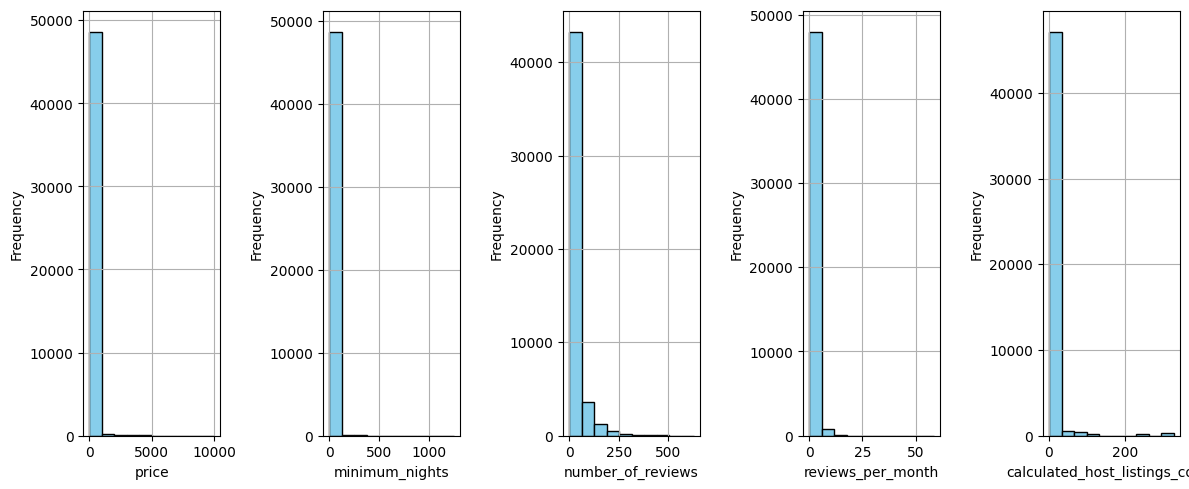

In [12]:
# Only plot histograms for these columns
selected_columns = ['price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count']  

# Plot histograms
fig, axes = plt.subplots(1, len(selected_columns), figsize=(12, 5))

for ax, col in zip(axes, selected_columns):
    df[col].plot(kind='hist', ax=ax, color='skyblue', edgecolor='black')
    ax.set_xlabel(col)
    ax.grid(True)

plt.tight_layout() # minimize spacing between plots
plt.show()

As we can see, price above 5000 dollars is extremely unreasonable. But, I found most of these to be luxury apartments. Since price = 0 does not make sense, but price being 5000+ dollars could be reasonable for luxury apartments in an insanely expensive area. Additinally, these are few values, over a dataset of ~49k, they will have close to no influence on actual mean. Likewise, anything above 500 for minimum_nights, 500 for number_of_reviews, and 50 for reviews_per_month is suspicious, but they do not negatively affect the data as values like 0 minimum_nights would. The calculated_host_listings_count is fine as there are enough listings around that price. Now, I will move onto question 2.

# Question 2

To find out the top 5 and bottom 5 neighbourhoods, I need to first group by neighbourhood and filter out the neighbourhoods with at most 5 listings. Then, I have to figure out average price of listings in neighbourhood. I group by neighbourhood_groups also to get average price of a neighbourhood as there may or may not be two neighbourhoods with exact same name in different neighbourhood groups. After, I sort the neighbourhoods by average price and via neighbourhood groups to finally be able to extract the top 5 and bottom 5 listings in each neighbourhood group as seen below. 

In [13]:
out = df[['neighbourhood_group', 'neighbourhood', 'price']] # we don't need the rest of columns
out = out.groupby('neighbourhood').filter(lambda x: len(x) > 5) # we only need neighbourhoods with more than 5 listings 
# average prices by neighbourhood
out = out.groupby(['neighbourhood_group', 'neighbourhood'])['price'].mean().reset_index() # We want to average for neighbourhoods and their groups (there can be 2 neighbourhoods with same name from different groups)
out.rename(columns={'price': 'average_price'}, inplace=True) # For readability
out = out.sort_values(by=["neighbourhood_group", "average_price"]) # sort so that we have it groups by neighbourhood_group with each neighbourhood
print(out)

    neighbourhood_group  neighbourhood  average_price
16                Bronx    Hunts Point      50.500000
36                Bronx        Tremont      51.545455
34                Bronx      Soundview      53.466667
3                 Bronx      Bronxdale      57.105263
24                Bronx     Mount Eden      58.500000
..                  ...            ...            ...
185       Staten Island     St. George     118.145833
188       Staten Island    Tottenville     144.857143
183       Staten Island    Shore Acres     152.714286
176       Staten Island    Grymes Hill     159.142857
181       Staten Island  Randall Manor     336.000000

[190 rows x 3 columns]


**Bottom 5 Listings for Each Neighbourhood Group:**

In [14]:
# Bottom 5 Neighbourhoods based on average price for each neighbourhood group
bottom_5 = out.groupby('neighbourhood_group').head(n=5) # It's in ascending order
print(bottom_5)

    neighbourhood_group        neighbourhood  average_price
16                Bronx          Hunts Point      50.500000
36                Bronx              Tremont      51.545455
34                Bronx            Soundview      53.466667
3                 Bronx            Bronxdale      57.105263
24                Bronx           Mount Eden      58.500000
50             Brooklyn         Borough Park      63.066176
47             Brooklyn          Bensonhurst      75.786667
53             Brooklyn          Brownsville      76.459016
73             Brooklyn            Gravesend      79.014706
77             Brooklyn              Midwood      80.339450
102           Manhattan               Inwood      88.896825
106           Manhattan          Marble Hill      89.166667
120           Manhattan   Washington Heights      89.610679
112           Manhattan     Roosevelt Island     113.259740
108           Manhattan  Morningside Heights     114.783237
132              Queens               Co

**Top 5 Listings for Each Neighbourhood Group:**

In [15]:
# TOP 5 Neighbourhoods based on average price for each neighbourhood group
top_5 = out.groupby('neighbourhood_group').tail(n=5)
print(top_5)

    neighbourhood_group       neighbourhood  average_price
41                Bronx  Westchester Square     122.200000
37                Bronx           Unionport     137.142857
11                Bronx         Eastchester     141.692308
5                 Bronx         City Island     173.000000
32                Bronx           Riverdale     442.090909
87             Brooklyn        Vinegar Hill     187.176471
63             Brooklyn               DUMBO     196.305556
52             Brooklyn    Brooklyn Heights     209.064935
58             Brooklyn         Cobble Hill     211.929293
83             Brooklyn            Sea Gate     487.857143
113           Manhattan                SoHo     287.103352
110           Manhattan                NoHo     295.717949
97            Manhattan   Flatiron District     341.925000
90            Manhattan   Battery Park City     367.557143
116           Manhattan             Tribeca     490.638418
125              Queens             Bayside     157.9487

Now, to determine the extent of price variation, I will use the mean from previous example to plot a Histogram for each neighbourhood group. I use 500 as the limit for y-axis since the mean is around 100 for all neighbourhood groups, but so many outliers in price and beyond the upper quartile range. I think the limit 500 shows a good understanding of how these 'outliers' vary by each neighbourhood group too. 

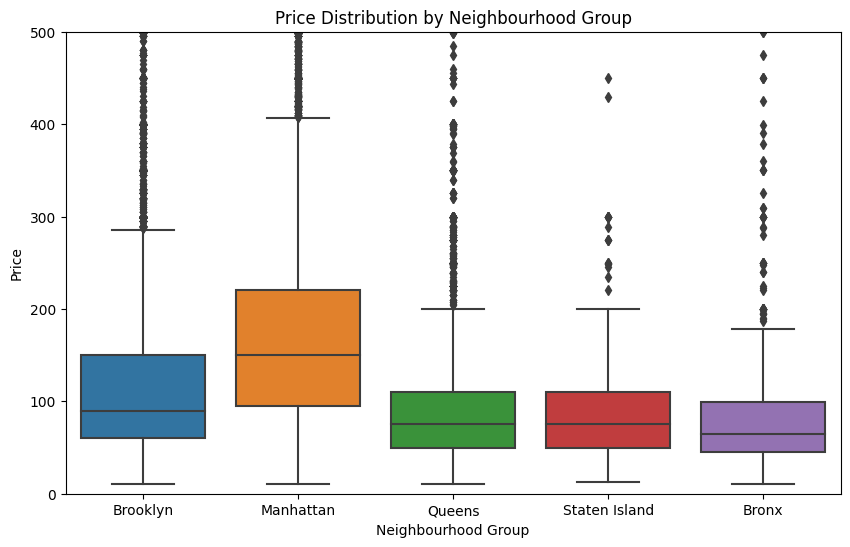

In [29]:
out = df[['neighbourhood_group', 'price']] # We don't need the other columns
# out = out.groupby('neighbourhood_group')['price'].mean().reset_index() # Group by neighbourhood group, calculate the average. 

plt.figure(figsize=(10, 6))
sns.boxplot(data=out, x='neighbourhood_group', y='price')

plt.title("Price Distribution by Neighbourhood Group")
plt.xlabel("Neighbourhood Group")
plt.ylabel("Price")
plt.ylim(0, 500) # limit upper end to avoid bad output
plt.show()

# Question 3

**Set of interesting features: price, minimum_nights, number_of_reviews, calculated_host_listings**

I will plot the following:
1. price vs minimum_nights correlation
2. price vs number_of_reviews correlation
3. 

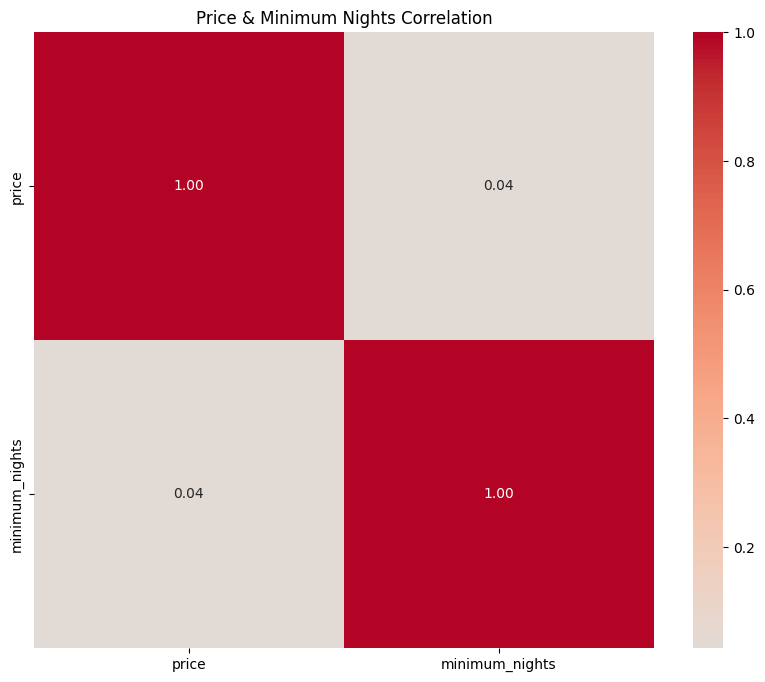

In [66]:
columns = ['price', 'minimum_nights']
correlation_matrix = df[columns].corr(method='pearson')
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt="0.2f", cmap="coolwarm", center=0)
plt.title("Price & Minimum Nights Correlation")
plt.show()

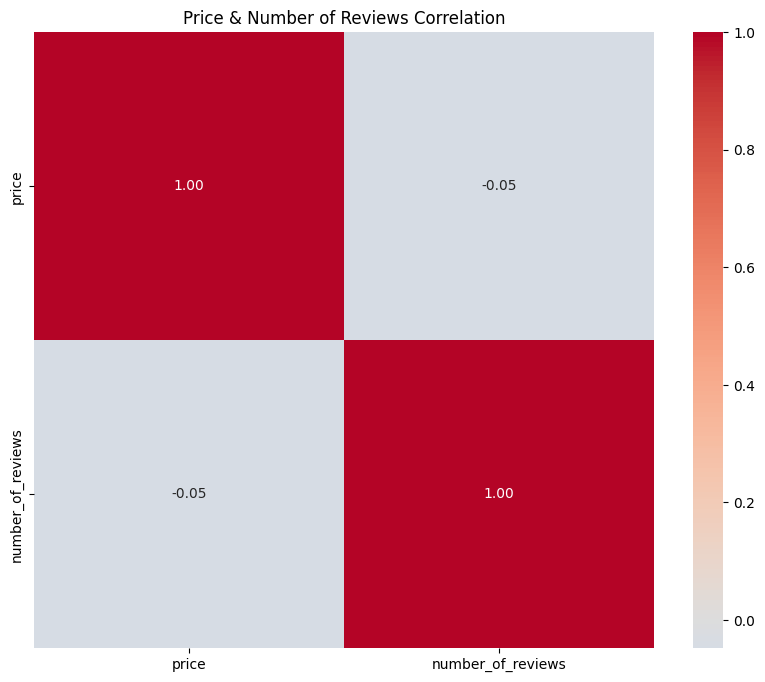

In [80]:
columns = ['price', 'number_of_reviews']
correlation_matrix = df[columns].corr(method='pearson')
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt="0.2f", cmap="coolwarm", center=0)
plt.title("Price & Number of Reviews Correlation")
plt.show()

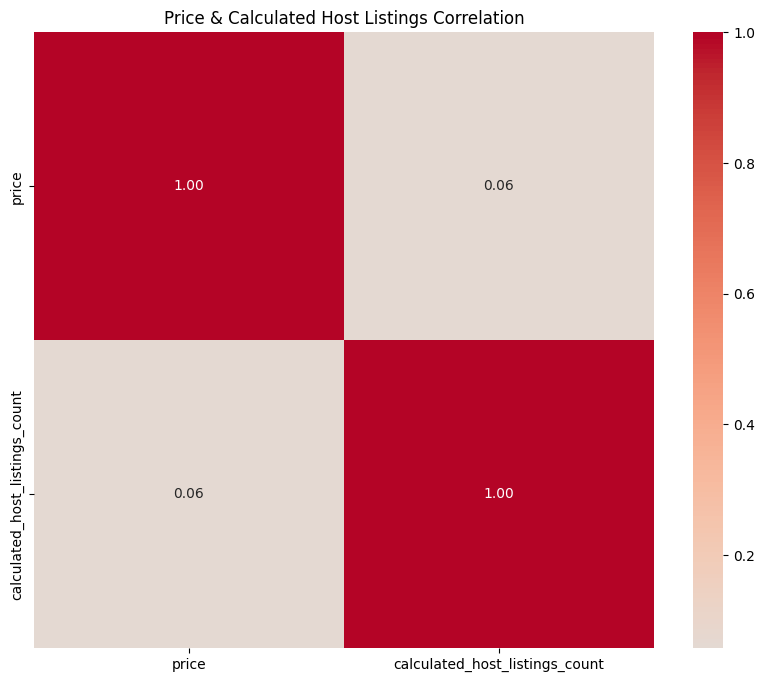

In [83]:
columns = ['price', 'calculated_host_listings_count']
correlation_matrix = df[columns].corr(method='pearson')
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt="0.2f", cmap="coolwarm", center=0)
plt.title("Price & Calculated Host Listings Correlation")
plt.show()

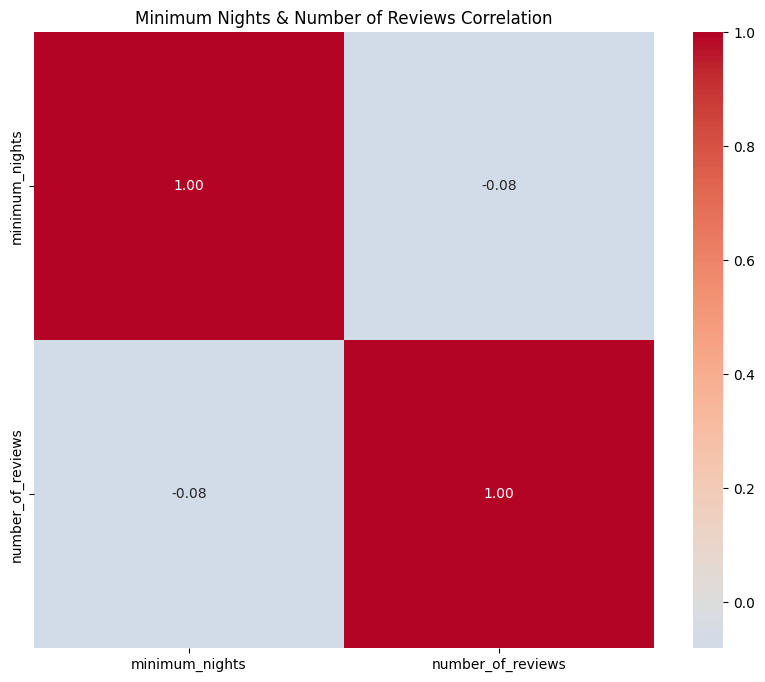

In [82]:
columns = ['minimum_nights', 'number_of_reviews']
correlation_matrix = df[columns].corr(method='pearson')
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt="0.2f", cmap="coolwarm", center=0)
plt.title("Minimum Nights & Number of Reviews Correlation")
plt.show()


**Strongest positive correlation 0.06 between price & calculated host listings**

**Strongest anti correlation -0.08 between minimum nights and the number of reviews**


# Question 4

I use seaborn with matplotlib to plot a scatterplot using longitude for x-axis, latitude for y-axis, and neighbourhood_group as hue for color coding. I stick to default "Set1" for the actual coloring, which is nice enough visually to differentiate the different boroughs of New York City. 

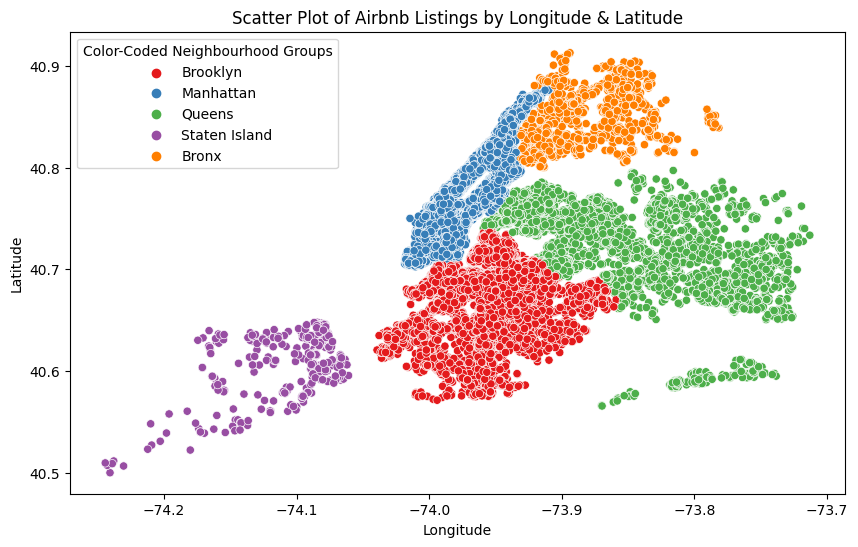

In [72]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='longitude', y='latitude', hue='neighbourhood_group', palette='Set1')
plt.title('Scatter Plot of Airbnb Listings by Longitude & Latitude')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Color-Coded Neighbourhood Groups')
plt.show()

First, I filter for Airbnb listings that are at most 1000 dollars. Then, I make a copy to avoid the SettingWithCopyWarning. Then, I create bins for ranges 0-100, 100-250, 250-500, 500-1000 alongside labels to use with the scatter plot. Then, I create a price_range column which labels different listings with the labels within the ranges described for bins for easily plotting a scatter plot. Now, I use these unequal ranges because the motivation is that a rich person will not care if a listing is 800 dollars or 900 dollars, whereas the poor person will certainly care about a difference between 50 and 80 dollar listing. Additionally, this is just me trying to show the essence of wealth distribution - a power law based phenomena. 

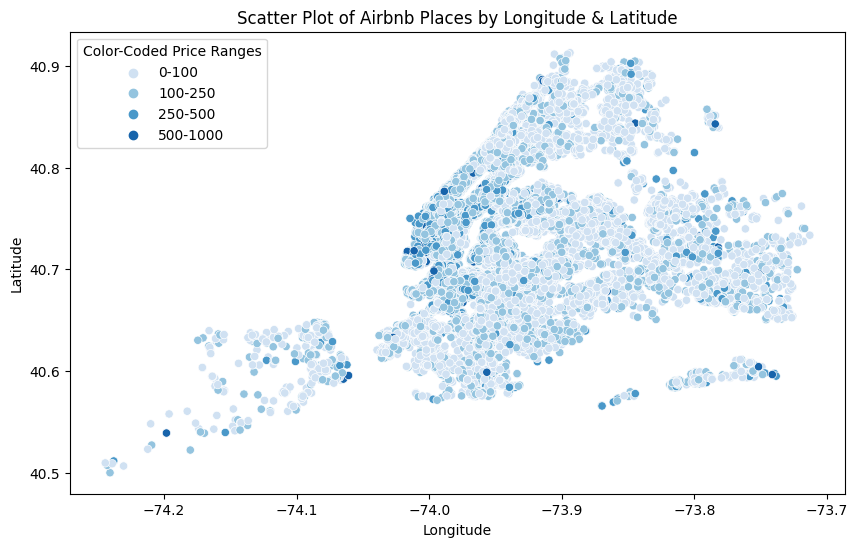

In [74]:
out = df[df['price'] < 1000] # Filter for only listings below $ 1,000
out = out.copy() # Avoid SettingWithCopyWarning warning

bins = [0, 100, 250, 500, 1000] 
labels = ['0-100', '100-250', '250-500', '500-1000']
out.loc[:, 'price_range'] = pd.cut(out['price'], bins=bins, labels=labels, right=False) # Create a price_range column using the bins & labels

plt.figure(figsize=(10,6))
sns.scatterplot(data=out, x='longitude', y='latitude', hue='price_range', palette='Blues') # Choose palette Blues for cleaner shading of which area is more expensive
plt.title('Scatter Plot of Airbnb Places by Longitude & Latitude')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Color-Coded Price Ranges')
plt.show()

# [](http://)Question 5
**I used wordcloud library as it was allowed by professor on piazza**

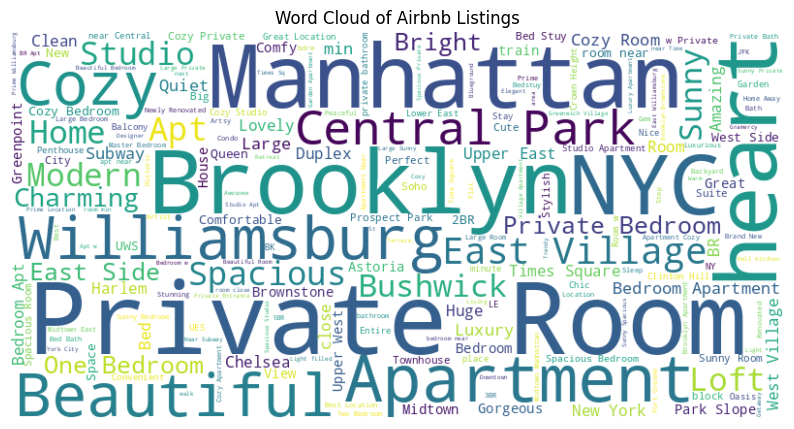

In [84]:
text = " ".join(df['name'].dropna()) # Join all name values into one single string
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text) # create wordcloud
plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Airbnb Listings')
plt.show()

# Question 6

First, I create bins and labels just like previous scatter plots of color-coding by Host Listings Count value. Then, I create the column that labels using the provided bins and labels list. Then, I use orange palette to show which areas were more busy as ornage indicates "hot" in a heatmap type map - in this case the color-coded scatter plot acts a lot like a heatmap. As it can be seen, the majority of listings are in Manhattan or more accurately, the majority of high listing hosts are in Manhattan. 

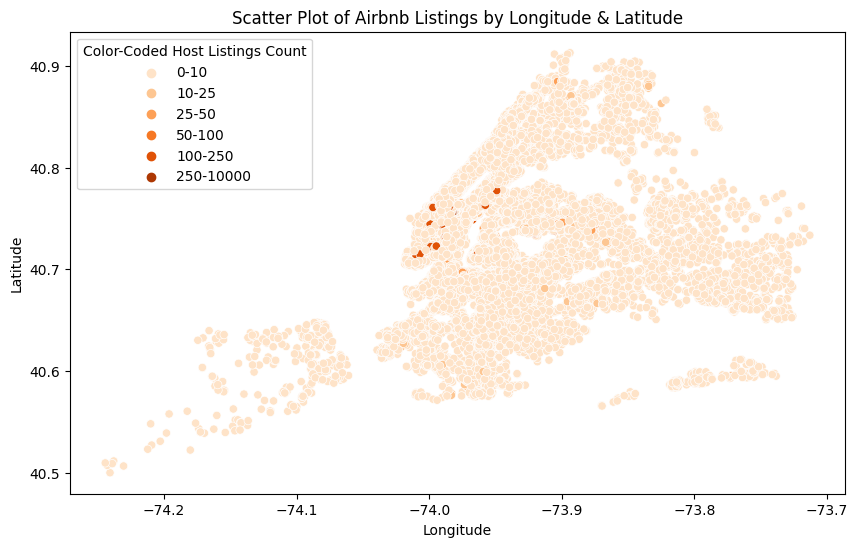

In [75]:
out = df
bins = [0, 10, 25, 50, 100, 250, 10000] 
labels = ['0-10', '10-25', '25-50', '50-100', '100-250', '250-10000']
out.loc[:, 'hostings_range'] = pd.cut(df['calculated_host_listings_count'], bins=bins, labels=labels, right=False) # Create a price_range column using the bins & labels

plt.figure(figsize=(10,6))
sns.scatterplot(data=out, x='longitude', y='latitude', hue='hostings_range', palette='Oranges') # Choose palette Oranges to stress busy areas
plt.title('Scatter Plot of Airbnb Listings by Longitude & Latitude')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Color-Coded Host Listings Count')
plt.show()

To put a number to each neighbourhood group, I did the average of calculated host listings and as it can be seen, Manhattan far surpasses in host listings than other boroughs. 

In [37]:
out = df[["neighbourhood_group", "calculated_host_listings_count"]]
out = out.groupby('neighbourhood_group')['calculated_host_listings_count'].mean().reset_index()
out.head() # There are only 5 neighbourhood groups aka boroughs

,neighbourhood_group,calculated_host_listings_count
0,Bronx,2.233731
1,Brooklyn,2.284371
2,Manhattan,12.791330
3,Queens,4.060184
4,Staten Island,2.319035


Now, I plot a bunch of correlations to further examine the claim and as it can be seen from the following correlations plus the ones from Question 3, the strongest correlation is between availability 365 and calculated host listings. This gives us a natural insight - many of Manhattan properties for Airbnb are readily available because they exist to make money from Airbnb. Additionally, another strong correlation was between Calculated Host Listings and Minimum Nights of r = 0.13. Other correlations were not as strong such as the one between price & calculated host listings correlation of around 0.06  

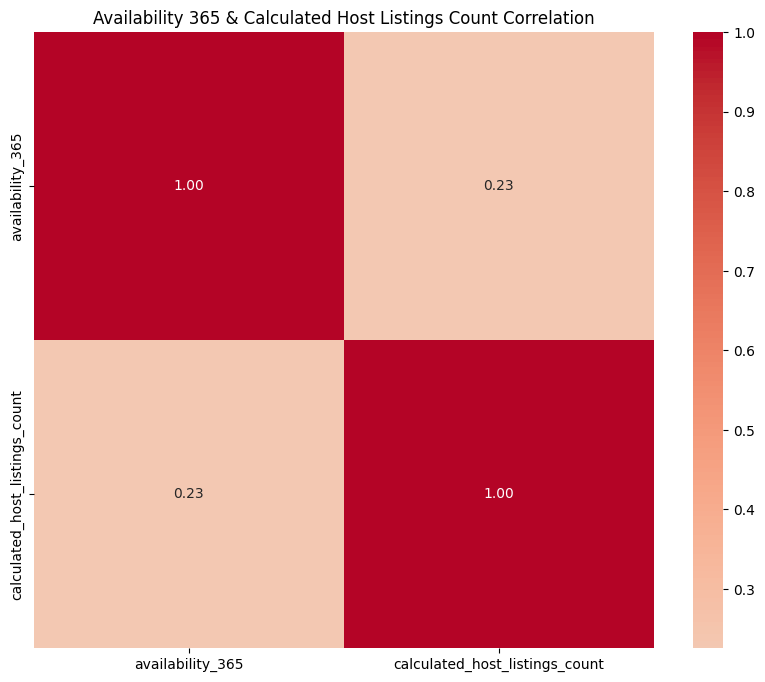

In [85]:
columns = ['availability_365', 'calculated_host_listings_count']
correlation_matrix = df[columns].corr(method='pearson')
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt="0.2f", cmap="coolwarm", center=0)
plt.title("Availability 365 & Calculated Host Listings Count Correlation")
plt.show()

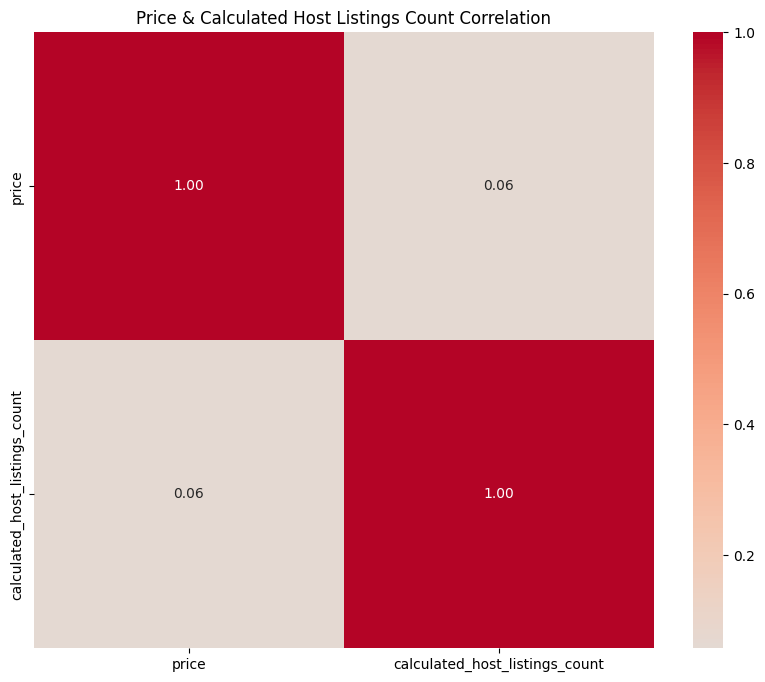

In [87]:
columns = ['price', 'calculated_host_listings_count']
correlation_matrix = df[columns].corr(method='pearson')
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt="0.2f", cmap="coolwarm", center=0)
plt.title("Price & Calculated Host Listings Count Correlation")
plt.show()

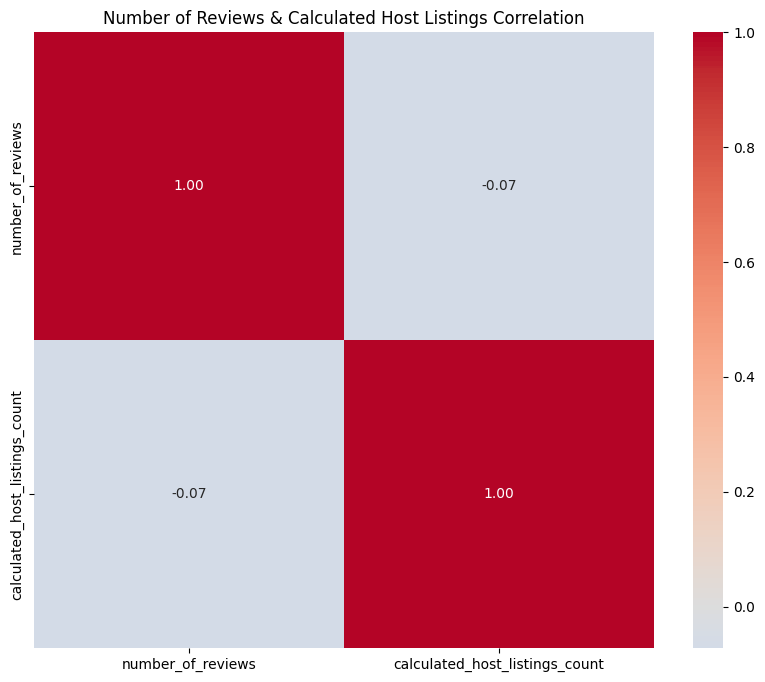

In [88]:
columns = ['number_of_reviews', 'calculated_host_listings_count']
correlation_matrix = df[columns].corr(method='pearson')
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt="0.2f", cmap="coolwarm", center=0)
plt.title("Number of Reviews & Calculated Host Listings Correlation")
plt.show()

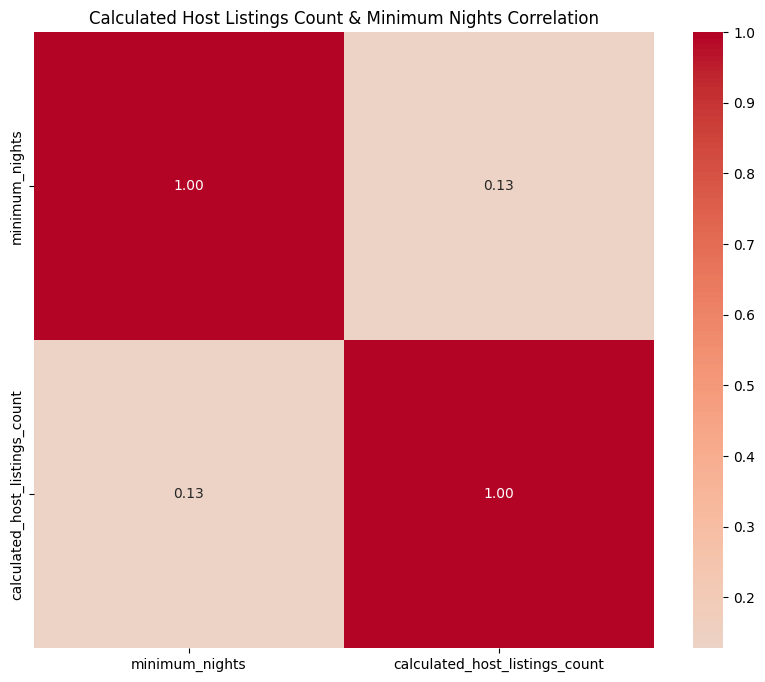

In [86]:
columns = ['minimum_nights', 'calculated_host_listings_count']
correlation_matrix = df[columns].corr(method='pearson')
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt="0.2f", cmap="coolwarm", center=0)
plt.title("Calculated Host Listings Count & Minimum Nights Correlation")
plt.show()

# Question 7

**Unique Plot 1 - Scatterplot of longitude/latitude, color-coding for number of reviews**

I consider this interesting because it could be considered in terms of finding locations that are heavily discussed, or perhaps have the most number of negative reviews driving up traffic, or even for algorithmic updates based on number of reviews of given locations. 

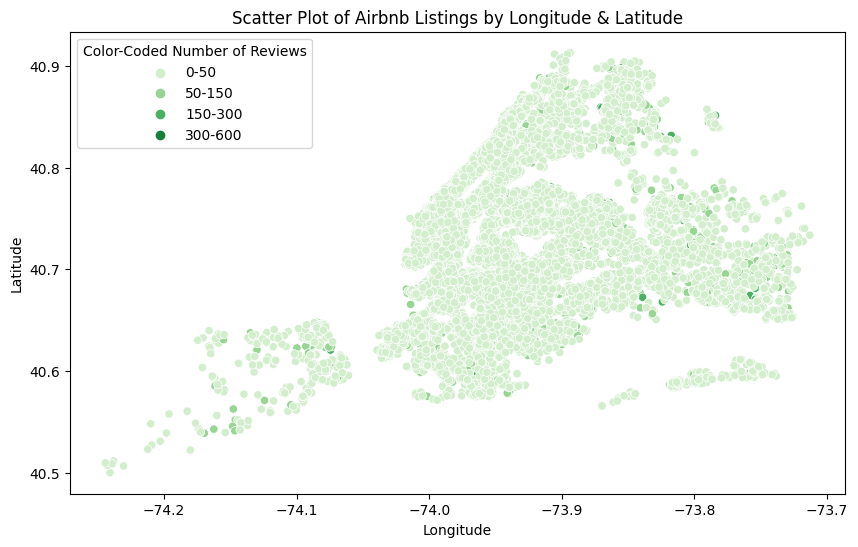

In [76]:
out = df # reset out variable to dataframe
bins = [0, 50, 150, 300, 600] 
labels = ['0-50', '50-150', '150-300', '300-600']
out.loc[:, 'reviews_range'] = pd.cut(out['number_of_reviews'], bins=bins, labels=labels, right=False) # Create a price_range column using the bins & labels

plt.figure(figsize=(10,6))
sns.scatterplot(data=out, x='longitude', y='latitude', hue='reviews_range', palette='Greens') # Choose palette Oranges to stress busy areas
plt.title('Scatter Plot of Airbnb Listings by Longitude & Latitude')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Color-Coded Number of Reviews')
plt.show()

The below is an average on number of reviews to further corrobarate which areas were picked on the scatter plot. 

In [56]:
out = df # reset out variable to dataframe
out = out.groupby(['neighbourhood', 'neighbourhood_group'])['number_of_reviews'].mean().reset_index()
out.rename(columns={'number_of_reviews': 'average_number_of_reviews'}, inplace=True) # For readability
out = out.sort_values(by=["average_number_of_reviews"], ascending=False) # sort so that we have it groups by neighbourhood_group with each neighbourhood
out.head(n=20)

,neighbourhood,neighbourhood_group,average_number_of_reviews
177,Silver Lake,Staten Island,118.500000
59,East Elmhurst,Queens,81.659459
165,Richmondtown,Staten Island,79.000000
69,Eltingville,Staten Island,76.000000
135,Mount Eden,Bronx,70.000000
183,Springfield Gardens,Queens,69.094118
194,Tompkinsville,Staten Island,57.142857
101,Huguenot,Staten Island,55.666667
120,Manhattan Beach,Brooklyn,50.625000
96,Highbridge,Bronx,48.814815


**Unique Plot 2 - Piechart of Each Neighbourhood Group's Share of Listings**

I consider this also an important chart because we need to know which neighbourhood groups dominate majority of the listings. As we can see, mainly two - Brooklyn and Manhattan dominate the Airbnb listings. This is important as it can be useful information on further understanding the nature of the dataset, and for making predictions based on some model. 

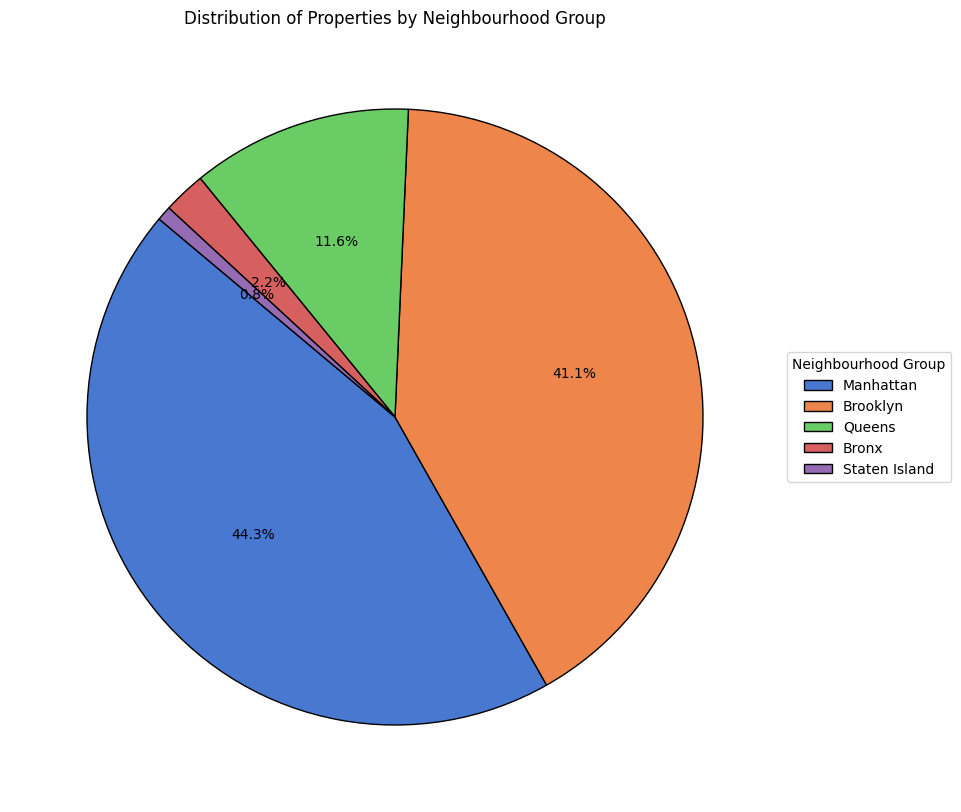

In [89]:
plt.figure(figsize=(10, 10))
out = df

neighbourhood_counts = out['neighbourhood_group'].value_counts() # Count up each neighbourhood group
wedges, texts, autotexts = plt.pie(neighbourhood_counts, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('muted', len(neighbourhood_counts)), wedgeprops={'edgecolor': 'black'}) # plot the chart
plt.legend(wedges, neighbourhood_counts.index, title="Neighbourhood Group", loc="center left", bbox_to_anchor=(1, 0.5)) # Add legends

plt.title('Distribution of Properties by Neighbourhood Group')
plt.show()